In [6]:
#load the data

import pandas as pd
import numpy as np
data=pd.read_csv("ad_click_dataset.csv")
data.head()


,id,full_name,age,gender,device_type,ad_position,browsing_history,time_of_day,click
0,670,User670,22.0,NaN,Desktop,Top,Shopping,Afternoon,1
1,3044,User3044,NaN,Male,Desktop,Top,NaN,NaN,1
2,5912,User5912,41.0,Non-Binary,NaN,Side,Education,Night,1
3,5418,User5418,34.0,Male,NaN,NaN,Entertainment,Evening,1
4,9452,User9452,39.0,Non-Binary,NaN,NaN,Social Media,Morning,0


In [8]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                10000 non-null  int64  
 1   full_name         10000 non-null  object 
 2   age               5234 non-null   float64
 3   gender            5307 non-null   object 
 4   device_type       8000 non-null   object 
 5   ad_position       8000 non-null   object 
 6   browsing_history  5218 non-null   object 
 7   time_of_day       8000 non-null   object 
 8   click             10000 non-null  int64  
dtypes: float64(1), int64(2), object(6)
memory usage: 703.3+ KB


In [10]:
data.describe()


,id,age,click
count,10000.000000,5234.000000,10000.000000
mean,5060.211400,40.197363,0.650000
std,2861.758265,13.126420,0.476993
min,5.000000,18.000000,0.000000
25%,2529.000000,29.000000,0.000000
50%,5218.000000,39.500000,1.000000
75%,7466.000000,52.000000,1.000000
max,10000.000000,64.000000,1.000000


In [12]:
data.describe(include=['object'])

,full_name,gender,device_type,ad_position,browsing_history,time_of_day
count,10000,5307,8000,8000,5218,8000
unique,4000,3,3,3,5,4
top,User1171,Female,Desktop,Bottom,Entertainment,Morning
freq,25,1834,2754,2817,1175,2126


In [14]:
data.isnull().sum()

id                     0
full_name              0
age                 4766
gender              4693
device_type         2000
ad_position         2000
browsing_history    4782
time_of_day         2000
click                  0
dtype: int64

In [16]:
avg_click_rate=data.click.mean()
avg_click_rate

0.65

<Axes: xlabel='age', ylabel='Count'>

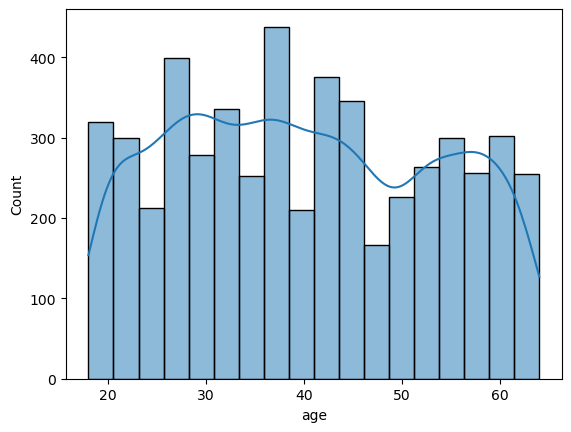

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(data=data,x="age",kde=True)

In [28]:
median_age=data["age"].median()
median_age

39.5

In [30]:
mean_age=data["age"].mean()
mean_age

40.197363393198316

<Axes: ylabel='age'>

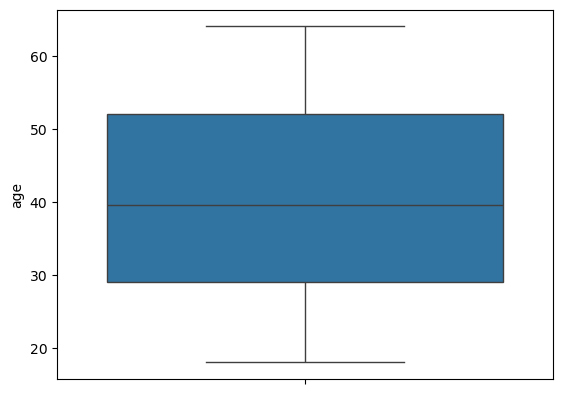

In [34]:
sns.boxplot(data=data,y="age")

In [36]:
#Filling missing values in numerical features

data['age']=data['age'].fillna(data['age'].median())



#Filling missing values in categorical features

data['gender']=data['gender'].fillna('Unknown')
data['browsing_history']=data['browsing_history'].fillna('Unknown')
data['time_of_day']=data['time_of_day'].fillna('Unknown')
data['device_type']=data['gender'].fillna(data['device_type'].mode())
data['ad_position']=data['gender'].fillna(data['ad_position'].mode())
data


,id,full_name,age,gender,device_type,ad_position,browsing_history,time_of_day,click
0,670,User670,22.0,Unknown,Unknown,Unknown,Shopping,Afternoon,1
1,3044,User3044,39.5,Male,Male,Male,Unknown,Unknown,1
2,5912,User5912,41.0,Non-Binary,Non-Binary,Non-Binary,Education,Night,1
3,5418,User5418,34.0,Male,Male,Male,Entertainment,Evening,1
4,9452,User9452,39.0,Non-Binary,Non-Binary,Non-Binary,Social Media,Morning,0
...,...,...,...,...,...,...,...,...,...
9995,8510,User8510,39.5,Unknown,Unknown,Unknown,Education,Unknown,0
9996,7843,User7843,39.5,Female,Female,Female,Entertainment,Unknown,0
9997,3914,User3914,39.5,Male,Male,Male,Unknown,Morning,0
9998,7924,User7924,39.5,Unknown,Unknown,Unknown,Shopping,Morning,1


In [82]:
# Checking whether the target variable 'click' is balanced or imbalanced

# Check raw counts
class_counts=data['click'].value_counts()
print(class_counts)


click
1    6500
0    3500
Name: count, dtype: int64


Text(0.5, 1.0, 'Class Distribution - Pie Chart')

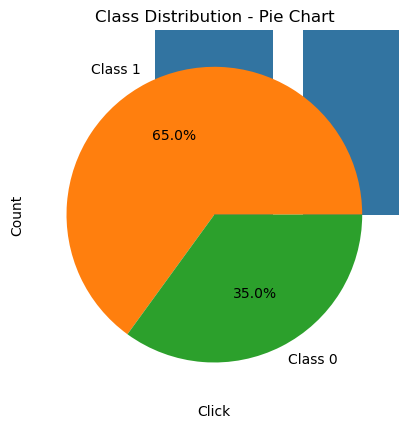

In [118]:
# Visualizing the class imbalance

# 1. Bar plot

labels=["Yes","No"]
class_count=[6500,3500]
sns.barplot(x=labels,y=class_count)
plt.title("Class Distribution")
plt.xlabel("Click")
plt.ylabel("Count")

# 2. Pie Chart

class_counts = data['click'].value_counts()
plt.pie(class_counts, labels=['Class 1', 'Class 0'],autopct='%1.1f%%')
plt.title('Class Distribution - Pie Chart')










In [46]:
# One hot encoding

from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# 1. Define the categorical columns
categorical_cols = ['gender', 'device_type', 'ad_position', 'browsing_history', 'time_of_day']

# 2. Initialize the OneHotEncoder
# sparse_output=False returns a standard array (easier to read)
# handle_unknown='ignore' ensures the model doesn't crash if it sees a new category later
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# 3. Fit and Transform the categorical columns
encoded_data = encoder.fit_transform(data[categorical_cols])

# 4. Convert back to a DataFrame with clear column names
encoded_cols = encoder.get_feature_names_out(categorical_cols)
df_encoded = pd.DataFrame(encoded_data, columns=encoded_cols)

# 5. Combine with 'age' and the target 'click'
# We drop the original columns and keep the numerical ones
df_final = pd.concat([data[['age', 'click']], df_encoded], axis=1)

print("Final dataset shape", df_final.shape)
print(df_final.head())


Final dataset shape (10000, 25)
    age  click  gender_Female  gender_Male  gender_Non-Binary  gender_Unknown  \
0  22.0      1            0.0          0.0                0.0             1.0   
1  39.5      1            0.0          1.0                0.0             0.0   
2  41.0      1            0.0          0.0                1.0             0.0   
3  34.0      1            0.0          1.0                0.0             0.0   
4  39.0      0            0.0          0.0                1.0             0.0   

   device_type_Female  device_type_Male  device_type_Non-Binary  \
0                 0.0               0.0                     0.0   
1                 0.0               1.0                     0.0   
2                 0.0               0.0                     1.0   
3                 0.0               1.0                     0.0   
4                 0.0               0.0                     1.0   

   device_type_Unknown  ...  browsing_history_Entertainment  \
0              

In [70]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 1. Separate Features (X) and Target (y)
X = df_final.drop('click', axis=1)
y = df_final['click']

# 2. Split into 80% Training and 20% Testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Train the Logistic Regression Model
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# Cross validation

from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation
# 'X' is your features, 'y' is your target
scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
print(scores)
print(f"Average Accuracy: {scores.mean()}")



[0.649  0.65   0.6495 0.651  0.651 ]
Average Accuracy: 0.6500999999999999


In [72]:
# 5. Make Predictions
y_pred = model.predict(X_test_scaled)

# 6. Check the Results
print(f"Model Accuracy: {accuracy_score(y_test, y_pred):.2%}")
print("\n--- Confusion Matrix ---")
print(confusion_matrix(y_test, y_pred))

Model Accuracy: 64.70%

--- Confusion Matrix ---
[[   3  702]
 [   4 1291]]


In [64]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the Forest (100 trees)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train_scaled, y_train)

# Check the new accuracy
rf_pred = rf_model.predict(X_test_scaled)
print(f"Random Forest Accuracy: {accuracy_score(y_test, rf_pred):.2%}")

Random Forest Accuracy: 70.95%
